## Read and plot the ensemble stats coming from the OCCIPUT 50xJason2-like SLA database

* This notebook aims at demonstrating how to open, read and plot the files shared on the MEOM opendap containing the ensemble statistiques from the the OCCIPUT 50xJason2-like SLA database.

* You can use the python module ```pydap``` and read the files __directly from the opendap__ as demonstrated below.

* You can also have a look at the other notebook ('readQUANTILES').

* Questions? : stephanie.leroux@ocean-next.fr


# module imports

In [1]:
## standart libraries
import os,sys
import numpy as np

# xarray
import xarray as xr

# to read files directly from opendap
from pydap.client import open_url

# plot
import cartopy.crs as ccrs
import cartopy.feature as ccf
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

from jdcal import gcal2jd, jd2gcal

%matplotlib inline 

# Define some functions for plot purposes

In [18]:
def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    import matplotlib as mpl
    import numpy as np
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap


def plotmapSCATT(fig1,ehonan,nav_lon,nav_lat,cm_base,vmin,vmax,Nincr,plto,glo=True,coastL=False,coastC=False,xlim=(0,10),ylim=(0,10),su='b',so='k',loncentr=0.,outonly=False, inonly=False):
        '''
        
        Plot regional or global map of scatter data (point by point data).
        Uses Cartopy.
        Parameters: (... description of the different parameters to to...)

        '''
        
        ## imports
        import os,sys
        import numpy as np

        # xarray
        import xarray as xr

        # plot
        import cartopy.crs as ccrs
        import cartopy.feature as ccf
        import matplotlib.pyplot as plt
        from matplotlib.colors import Colormap
        import matplotlib.colors as mcolors
        import matplotlib.dates as mdates
        import matplotlib.cm as cm
        import matplotlib.dates as mdates
        import matplotlib.ticker as mticker
        
        # Colormap & levels
        cmap = plt.get_cmap(cm_base)
        cmap.set_under(su,1.)
        cmap.set_over(so,1.) 
        levels = mticker.MaxNLocator(nbins=Nincr).tick_values(vmin, vmax)
        norm   = mcolors.BoundaryNorm(levels, ncolors=cmap.N)
        
        # Projection
        
        trdata  = ccrs.PlateCarree() 
        # Note: if data points are given in classical lat lon coordinates this should
        #       be set to ccrs.PlateCarree() whatever the map projection is.
        
        if glo:
            ax = plt.axes(projection=ccrs.Robinson(central_longitude=loncentr))
            # marker size
            sm=0.1
        else:
            ax = plt.axes(projection= ccrs.PlateCarree())
            # marker size
            sm=0.5
        
        if glo:
            ax.set_global() 
            
        if glo:
            ax.outline_patch.set_edgecolor('#585858')
        else:
            ax.outline_patch.set_edgecolor('white')
            

        # grid on map
        if glo:
            gl = ax.gridlines(linewidth=1, color='#585858', alpha=0.2, linestyle='--') 
        else:
            gl = ax.gridlines(draw_labels=True,linewidth=1, color='#585858', alpha=0.2, linestyle='--')
            # grid labels
            label_style = {'size': 12, 'color': 'black', 'weight': 'bold'}
            gl.xlabel_style = label_style
            gl.xlabels_bottom = False
            gl.xlocator = mticker.FixedLocator(np.arange(-180,180,20,dtype=float))
            gl.ylabel_style = label_style
            gl.ylabels_right = False
            gl.ylocator = mticker.FixedLocator(np.arange(-90,90,20,dtype=float))
       
        # Add Coastlines and or plain continents
        if coastC:
            ax.add_feature(ccf.LAND, facecolor='#585858', edgecolor='none')
        if coastL:
            ax.coastlines(color='#585858')
        
        ### PLOTS:
        
        if inonly==False:
            # plot points where rank is 0
            cs2 = plt.scatter(nav_lon.where(ehonan==0.), nav_lat.where(ehonan==0.), s=sm, marker="D",color=su,transform=trdata,norm=norm,vmin=vmin,vmax=vmax)
            # plot points where rank is 1
            cs3 = plt.scatter(nav_lon.where(ehonan==1.), nav_lat.where(ehonan==1.), s=sm,  marker="D",color=so,transform=trdata,norm=norm,vmin=vmin,vmax=vmax)
            # plot points where rank is different from 0 and 1 (true obs in the model pdf)
        
        if outonly==False:
            cs = plt.scatter(nav_lon.where((ehonan!=1.)&(ehonan!=0.)), nav_lat.where((ehonan!=1.)&(ehonan!=0.)), s=sm, marker="D", c=ehonan.where((ehonan!=1.)&(ehonan!=0.)), cmap=cmap,transform=trdata,norm=norm,vmin=vmin,vmax=vmax)
            #cs = plt.scatter(nav_lon, nav_lat, s=sm, marker="D", c=ehonan, cmap=cmap,transform=trdata,norm=norm,vmin=vmin,vmax=vmax)
        
        if glo==False:
            #limits
            plt.xlim(xlim)
            plt.ylim(ylim) 

        # plot colorbar
        cb = plt.colorbar(cs, extend='both',  pad=0.04, orientation='horizontal', shrink=0.75)
        cb.ax.tick_params(labelsize=15) 
        cb.set_label(labelplt,size=15)
        ticks = np.linspace(vmin,vmax,11)
        cb.set_ticks(ticks)
        new_tickslabels = ["%.2f" % i for i in ticks]
        cb.set_ticklabels(new_tickslabels)

# Some parameters

In [4]:
# opendap url:
baseurl = 'https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/dodsC/meomopendap/extract/ORCA025.L75-OCCITENS-S/OBS-SLA/STATS/'

# directory where to save plots
diro='./plots/'

# name of variable in .cobs files (from Sesam)
varna='JASON'

# TIME coordinate:
# cnes reference julian date 
cnesjdref = 2433282.5 
# will use package jdcal to convert julian days to dates


# unit to appear in plot title
unitna = 'm'

# output res and format
dpifig=150
pltty = ".png"

# Read the dataset

 WILL READ THE DATASET DIRECTLY FROM THE OPENDAP
 
 Note that when reading from opendap, wildcards are not allowed so it is not possible to use xr.open_mfdataset to open all files
 Instead, we have to read explicitely all files and concastenate them


In [5]:
# WILL READ THE DATASET DIRECTLY FROM THE OPENDAP
# note that when reading from opendap, wildcards are not allowed so it is not possible to use xr.open_mfdataset to open all files
# instead, we have to read explicitely all files and concastenate them

it=0
# loop om all time segments
for seg in np.arange(21550,24111):
    it=it+1
    test=1

    # name of input directory (directly from the opendap)
    namdir      = 'RANK50ERROBSrmTM_'+str(seg)+'_0011/'
    
    # path
    path2file = baseurl+namdir+'rank_JASON.cobs' 

    # read
    try:
        rank = xr.open_dataset(path2file)[varna] 
        lat  = xr.open_dataset(path2file)['lat'] 
        lon  = xr.open_dataset(path2file)['lon']
    except:
        #print('skip this segment (does not exist): '+str(seg))
        test=0
        
    if test==1:  
        # concatenate
        if it>1:
            allrank = xr.concat([allrank,rank], dim='obsidx')
            alllat  = xr.concat([alllat,lat], dim='obsidx')
            alllon  = xr.concat([alllon,lon], dim='obsidx')
        else: 
            allrank = rank
            alllat = lat
            alllon = lon       

## rewrite data as xarrays with lat as coordinate

In [7]:
# rewrite data as xarrays with lat as coordinate (this will then permit to group the rank array by latitude values):
xrrank =  xr.DataArray(allrank.values,coords=[alllat], dims=['lat'],name=varna)
xrlat =   xr.DataArray(alllat.values,coords=[alllat], dims=['lat'],name='lati')
xrlon =   xr.DataArray(alllon.values,coords=[alllat], dims=['lat'],name='lon')

# Mean rank map

## - Compute time-mean rank and associated coordinates

In [8]:
# time-mean rank over the entire period 2009-2015
TMrank    = xrrank.groupby('lat').mean(skipna=True)

# store number of occurrences at each location
occurrences = xrrank.groupby('lat').count()

# make it an xarray again for later use
occurrences = xr.DataArray(occurrences,name='TMoccurrences')

# Proceed the same way with the latitude array ...
TMlat    =  xrlat.groupby('lat').mean(skipna=True)

# ... and the longitude array
TMlon    =  xrlon.groupby('lat').mean(skipna=True)

# ...and also compute min and max longitude for later check (see explanation just below)
MINlon =  xrlon.groupby('lat').min()
MAXlon =  xrlon.groupby('lat').max()


### - Checking the ```groupby``` approach


#### Note: 
The difference MAXlon-MINlon will be computed as a check: xrrank is grouped by identical **latitude** values. In the along-track context, these latitude values should almost each  correspond to a unique along-track location around the globe (meaning a given lat value always corresponds to the same longitude value). As a check, and to eliminate the few latitudes for which the above is not true, we use the longitude array,  also grouped by its latitude coordinate. If the above statement is true, then MAXlon - MINlon should be 0. It is mostly the case but there are about 1% of the points where it is not true (meaning a few latitude values can correspond to different longitude values). We thus discard those points before diagnostics and plots._

In [9]:
# check (see explanation below)
difflon =  MAXlon - MINlon

print('---removed points (%):')
Ndiff = difflon.where(difflon!=0,drop=True).size
Ntot = difflon.size
print(Ndiff*100/Ntot)

---removed points (%):
1.108594140341782


In [12]:
baseurl

'https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/dodsC/meomopendap/extract/ORCA025.L75-OCCITENS-S/OBS-SLA/STATS/'

# make custom colormap

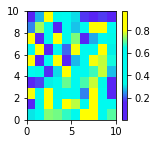

In [19]:
### colors to include in my custom colormap
#colors=[(255,255,0),(255,255,0),(250,0,0),(255,0,0),(250,0,0),(88,36,245),(88,36,245)]
colors=[(255,255,0),(255,255,0),(0,250,240),(0,250,240),(0,250,230),(88,36,245),(88,36,245)]
#colors=[(169,247,242),(169,247,242),(200,254,46),(200,254,46),(200,254,46),(8,75,138),(8,75,138)]

### Call the function make_cmap which returns my colormap
my_cmap = make_cmap(colors[::-1], bit=True)

### Display my colormap
plotcolormap=True
if plotcolormap:
    fig = plt.figure(figsize=([2,2]),facecolor='white')
    #ax = fig.add_subplot(311)
    plt.pcolor(np.random.rand(10,10), cmap=my_cmap)
    plt.colorbar()
    plt.show() 
    plt.close(fig) 


In [27]:
# path
path2fileTM = baseurl+'TMmask2.nc' 
tm = xr.open_dataset(path2fileTM)['JASON']
TMlon = xr.open_dataset(path2fileTM)['lon']        
TMlat = xr.open_dataset(path2fileTM)['lat']

OSError: [Errno -90] NetCDF: file not found: b'https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/dodsC/meomopendap/extract/ORCA025.L75-OCCITENS-S/OBS-SLA/STATS/TMmask2.nc'

## - Plot global map of mean rank

2009-2015


/home/lerouste/.conda/envs/py36_steph_env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/lerouste/.conda/envs/py36_steph_env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


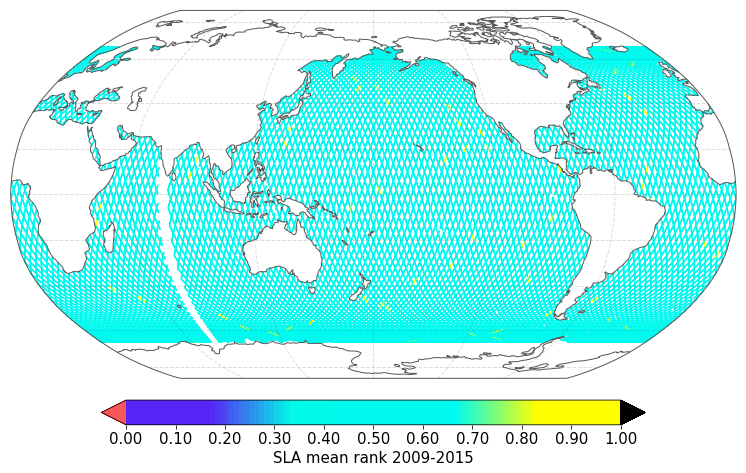

In [23]:
datena= '2009-2015'
print(datena)

# colormap
cm_base=my_cmap  #'Spectral_r'#cm_base=my_cmap #
# min/max values
vmin=0.
vmax=1.
Nincr=100
loncentr=180
cmap = plt.get_cmap(cm_base)
cmap


# data to plot:
data2plot = TMrank.where((difflon==0)&(tm<10.),drop=True).squeeze()
lat2plot  = TMlat.where((difflon==0)&(tm<10.),drop=True).squeeze()
lon2plot  = MINlon.where((difflon==0)&(tm<10.),drop=True).squeeze() 



plti="rank_obsERROBSrmTM"
plto = "GLOB180_c"+"_SLA."+plti+'_'+datena
labelplt= 'SLA mean rank '+datena

#------ START PLOTTING-----------------------------------------------------------------------
# create fig
fig1 = plt.figure(figsize=([13,10]),facecolor='white')

# plot data (base plot)
css =  plotmapSCATT(fig1,data2plot,lon2plot,lat2plot,cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,plto=plto,glo=True,loncentr=loncentr,coastL=True,su='#FA5858',so='k', inonly=True)   
plt.show()

# Save fig in png, resolution dpi
fig1.savefig(diro+"/"+plto+'.png', facecolor=fig1.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#
plt.close(fig1)       

In [22]:
tm

<xarray.DataArray 'JASON' (obsidx: 231755)>
array([4.220716e-02, 3.674196e-02, 3.356213e-02, ..., 9.955622e+04,
       9.955424e+04, 9.955816e+04], dtype=float32)
Dimensions without coordinates: obsidx

## - Regional map of mean rank

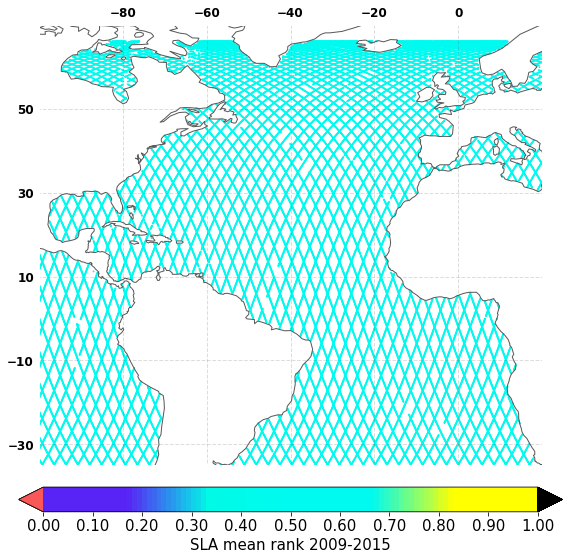

In [33]:

data2plot = TMrank.where((difflon==0)&(tm<10.),drop=True).squeeze()
lat2plot  = TMlat.where((difflon==0)&(tm<10.),drop=True).squeeze()
lon2plot  = MINlon.where((difflon==0)&(tm<10.),drop=True).squeeze() 

# plot title and output file title
plti="rank_obsERROBSrmTM"
plto = "NATL60_SLA."+plti+'_'+datena
labelplt='SLA mean rank '+datena

#------ START PLOTTING ------------
# create fig
fig1 = plt.figure(figsize=([13,10]),facecolor='white')

# plot data 
css =  plotmapSCATT(fig1,data2plot,lon2plot,lat2plot,cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,xlim=(-100,20),ylim=(-35,70) ,plto=plto,glo=False,coastL=True,coastC=False,su='#FA5858',so='k',inonly=True) #, 

plt.show()

# Save fig in png, resolution dpi
fig1.savefig(diro+"/"+plto+'.png', facecolor=fig1.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#
plt.close(fig1)  

## - Plot number of occurrences

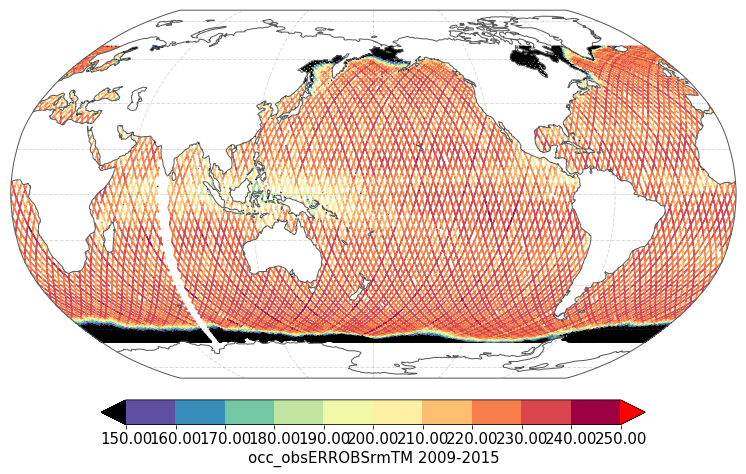

In [34]:
# colormap
cm_base='Spectral_r' #my_cmap  #'Spectral_r'#cm_base=my_cmap #
# min/max values
vmin=150.
vmax=250.
Nincr=10
loncentr=180
cmap = plt.get_cmap(cm_base)

data2plot = occurrences.where((difflon==0)&(tm<10.),drop=True).squeeze()
lat2plot = TMlat.where((difflon==0)&(tm<10.),drop=True).squeeze()
lon2plot = MINlon.where((difflon==0)&(tm<10.),drop=True).squeeze() 

plti="occ_obsERROBSrmTM"
plto = "GLOB180_c"+"_SLA."+plti+'_'+datena
labelplt= plti+' '+datena

#------ START PLOTTING-----------------------------------------------------------------------
# create fig
fig1 = plt.figure(figsize=([13,10]),facecolor='white')

# plot data (base plot)
css =  plotmapSCATT(fig1,data2plot,lon2plot,lat2plot,cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,plto=plto,glo=True,loncentr=loncentr,coastL=True,su='k',so='r',inonly=True)   
plt.show()

# Save fig in png, resolution dpi
fig1.savefig(diro+"/"+plto+'.png', facecolor=fig1.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#
plt.close(fig1)       

<hr><hr/>
# Percentage of occurrences when the obs is out of the model distribution (i.e. when rank is either 0 or 1)

## - Case rank=0

In [36]:
# Set all occurrences where rank=0 to 100. :
xrrank0only = xrrank.where(xrrank!=0,other=100.) 

# Set values other than 100 to 0
xrrank0only =  xrrank0only.where(xrrank0only==100,other=0)

# Compute mean value per latitude
# (this is a proxy for the % of occurrences where rank=0 at each location)
percR0 = xrrank0only.groupby('lat').mean(skipna=True)

# select only the locations where more than 150 occurrences are cumulated
percR0_select = xrrank0only.groupby('lat').mean(skipna=True).where(occurrences>150)


## - Case rank=1

In [37]:
# Set all occurrences where rank=0 to 100. :
xrrank1only = xrrank.where(xrrank!=1,other=100.) 

# Set values other than 100 to 0
xrrank1only =  xrrank1only.where(xrrank1only==100,other=0)

# Compute mean value per latitude
# (this is a proxy for the % of occurrences where rank=0 at each location)
percR1 = xrrank1only.groupby('lat').mean(skipna=True)

# select only the locations where more than 150 occurrences are cumulated
percR1_select = xrrank1only.groupby('lat').mean(skipna=True).where(occurrences>150)

## - GLOBAL maps

* __Plot parameters__

In [38]:
datena= '2009-2015'
print(datena)

# colormap
# colormap
cm_base='Spectral_r' #my_cmap  #'Spectral_r'#cm_base=my_cmap #
# min/max values

loncentr=180
cmap = plt.get_cmap(cm_base)
cmap

2009-2015


* __Case Rank=1__

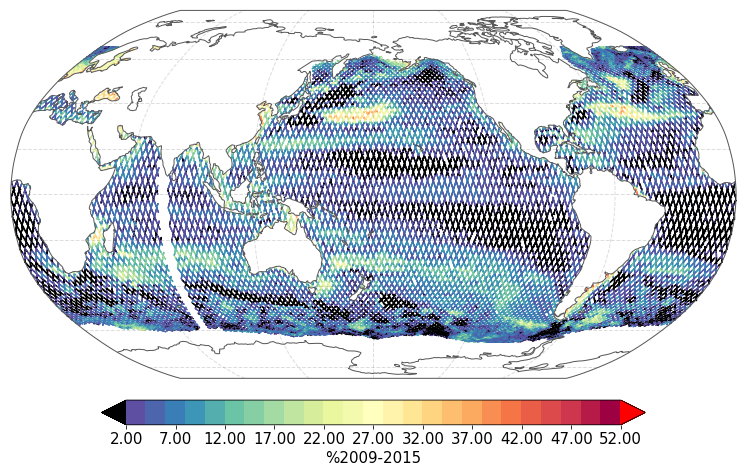

In [73]:
vmin=2.
vmax=52.
Nincr=25

data2plot = percR1_select.where((difflon==0)&(tm<10.),drop=True).squeeze()
lat2plot = TMlat.where((difflon==0)&(tm<10.),drop=True).squeeze()
lon2plot = MINlon.where((difflon==0)&(tm<10.),drop=True).squeeze() 

plti="percR1S_obsERROBSrmTM"
plto = "GLOB180_c"+"_SLA."+plti+'_'+datena
labelplt= '%'+datena

#------ START PLOTTING-----------------------------------------------------------------------
# create fig
fig1 = plt.figure(figsize=([13,10]),facecolor='white')

# plot data (base plot)
css =  plotmapSCATT(fig1,data2plot,lon2plot,lat2plot,cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,plto=plto,glo=True,loncentr=loncentr,coastL=True,su='k',so='r')   
plt.show()

# Save fig in png, resolution dpi
fig1.savefig(diro+"/"+plto+'.png', facecolor=fig1.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#
plt.close(fig1)       

* Case Rank=0

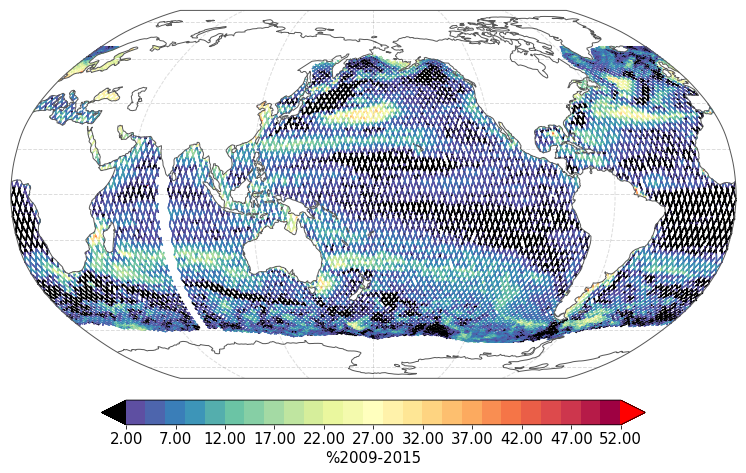

In [72]:
vmin=2.
vmax=52.
Nincr=25

data2plot = percR0_select.where((difflon==0)&(tm<10.),drop=True).squeeze()
lat2plot = TMlat.where((difflon==0)&(tm<10.),drop=True).squeeze()
lon2plot = MINlon.where((difflon==0)&(tm<10.),drop=True).squeeze() 

plti="percR0S_obsERROBSrmTM"
plto = "GLOB180_c"+"_SLA."+plti+'_'+datena
labelplt= '%'+datena

#------ START PLOTTING-----------------------------------------------------------------------
# create fig
fig1 = plt.figure(figsize=([13,10]),facecolor='white')

# plot data (base plot)
css =  plotmapSCATT(fig1,data2plot,lon2plot,lat2plot,cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,plto=plto,glo=True,loncentr=loncentr,coastL=True,su='k',so='r')   
plt.show()

# Save fig in png, resolution dpi
fig1.savefig(diro+"/"+plto+'.png', facecolor=fig1.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#
plt.close(fig1)       

* Case Rank=0 or 1

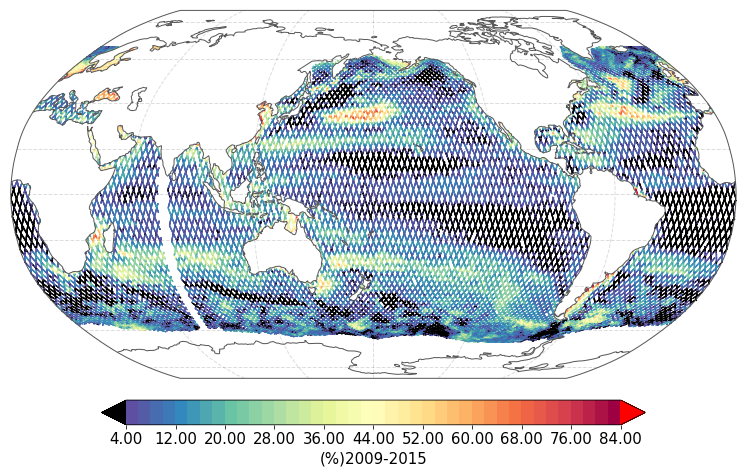

In [71]:
vmin=4.
vmax=84.
Nincr=40

data2plot = percR1_select.where((difflon==0)&(tm<10.),drop=True).squeeze()+percR0_select.where((difflon==0)&(tm<10.),drop=True).squeeze()
lat2plot = TMlat.where((difflon==0)&(tm<10.),drop=True).squeeze()
lon2plot = MINlon.where((difflon==0)&(tm<10.),drop=True).squeeze() 

plti="percOUTS_obsERROBSrmTM"
plto = "GLOB180_c"+"_SLA."+plti+'_'+datena
labelplt= '(%)'+datena

#------ START PLOTTING-----------------------------------------------------------------------
# create fig
fig1 = plt.figure(figsize=([13,10]),facecolor='white')

# plot data (base plot)
css =  plotmapSCATT(fig1,data2plot,lon2plot,lat2plot,cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,plto=plto,glo=True,loncentr=loncentr,coastL=True,su='k',so='r')   
plt.show()

# Save fig in png, resolution dpi
fig1.savefig(diro+"/"+plto+'.png', facecolor=fig1.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#
plt.close(fig1)    

## Regional maps

* Case (R=1 or R=0) 

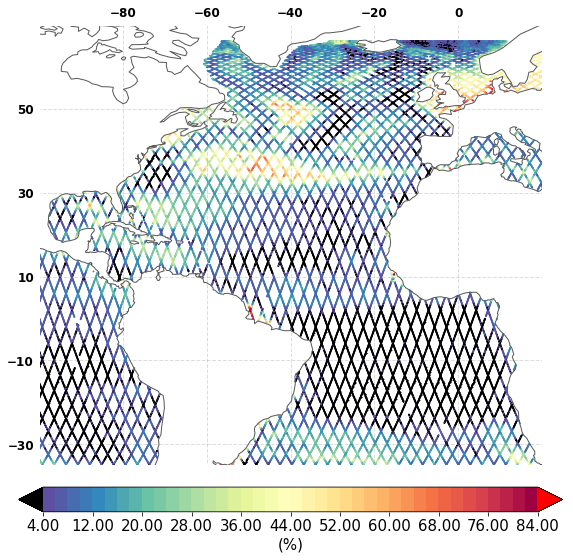

In [70]:
vmin=4.
vmax=84.
Nincr=40

data2plot = percR1_select.where((difflon==0)&(tm<10.),drop=True).squeeze()+percR0_select.where((difflon==0)&(tm<10.),drop=True).squeeze()
lat2plot = TMlat.where((difflon==0)&(tm<10.),drop=True).squeeze()
lon2plot = MINlon.where((difflon==0)&(tm<10.),drop=True).squeeze() 

#plot title and output file title
plti="percOUTS_obsERROBS"
plto = "NATL60_SLA."+plti+'_'+datena
labelplt= '(%)'


#------ START PLOTTING ------------
# create fig
fig1 = plt.figure(figsize=([13,10]),facecolor='white')

# plot data 
css =  plotmapSCATT(fig1,data2plot,lon2plot,lat2plot,cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,xlim=(-100,20),ylim=(-35,70) ,plto=plto,glo=False,coastL=True,coastC=False,su='k',so='r') #, 
#css2 = plt.scatter(-16.28,48.78 ,s=80, c="#0789B8", alpha=1., marker='s',edgecolors='w',zorder=10)
plt.show()

# Save fig in png, resolution dpi
fig1.savefig(diro+"/"+plto+'.png', facecolor=fig1.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#
plt.close(fig1)  